In [ ]:
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Union

import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.utils.tensorboard
from torch import Tensor
from tqdm import tqdm

import delu

import sys
import os
os.environ['PROJECT_DIR'] = '/Users/timgritsaev/Desktop/tabular/tabular-hpo'
sys.path.append('/Users/timgritsaev/Desktop/tabular/tabular-hpo')
import lib
from lib import KWArgs

import json
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt

import matplotlib as mlp

import seaborn as sns
import numpy as np
%config InlineBackend.figure_format = 'retina'

sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 10, 2 * 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
SMALL_SIZE = 7
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE) 
mlp.rcParams.update({"axes.grid" : True, "grid.color": "white"})
%matplotlib inline


@dataclass(frozen=True)
class Config:
    seed: int
    data: Union[lib.Dataset[np.ndarray], KWArgs]  # lib.data.build_dataset
    model: Union[nn.Module, KWArgs]  # Model
    optimizer: Union[torch.optim.Optimizer, KWArgs]  # lib.deep.make_optimizer
    batch_size: int
    patience: Optional[int]
    n_epochs: Union[int, float]


def _patch_config(c: lib.JSONDict):
    # update config format
    if isinstance(c['model'], dict) and 'backbone' not in c['model']:
        assert 'num_embeddings' in c
        c['model'] = {
            'num_embeddings': c.pop('num_embeddings'),
            'backbone': c.pop('model'),
        }


def prune_model(path_to_config, path_to_model, n_epochs, amount_to_prune):
    
    class Model(nn.Module):
        def __init__(
            self,
            *,
            n_num_features: int,
            n_bin_features: int,
            cat_cardinalities: list[int],
            n_classes: Optional[int],
            num_embeddings: Optional[dict],  # lib.deep.ModuleSpec
            backbone: dict,  # lib.deep.ModuleSpec
        ) -> None:
            assert n_num_features or n_bin_features or cat_cardinalities
            if num_embeddings is not None:
                assert n_num_features
            assert backbone['type'] in ['MLP', 'ResNet']
            super().__init__()

            if num_embeddings is None:
                self.m_num = nn.Identity() if n_num_features else None
                d_num = n_num_features
            else:
                self.m_num = lib.make_module(num_embeddings, n_features=n_num_features)
                d_num = n_num_features * num_embeddings['d_embedding']
            self.m_bin = nn.Identity() if n_bin_features else None
            self.m_cat = lib.OneHotEncoder(cat_cardinalities) if cat_cardinalities else None
            self.backbone = lib.make_module(
                backbone,
                d_in=d_num + n_bin_features + sum(cat_cardinalities),
                d_out=lib.get_d_out(n_classes),
            )
            self.flat = True

        def forward(
            self,
            *,
            x_num: Optional[Tensor],
            x_bin: Optional[Tensor],
            x_cat: Optional[Tensor],
        ) -> Tensor:
            x = []
            for module, x_ in [
                (self.m_num, x_num),
                (self.m_bin, x_bin),
                (self.m_cat, x_cat),
            ]:
                if x_ is None:
                    assert module is None
                else:
                    assert module is not None
                    x.append(module(x_))
            del x_  # type: ignore[code]
            if self.flat:
                x = torch.cat([x_.flatten(1, -1) for x_ in x], dim=1)
            else:
                # for Transformer-like backbones (currently unsupported)
                assert all(x_.ndim == 3 for x_ in x)
                x = torch.cat(x, dim=1)

            x = self.backbone(x)
            return x

    if path_to_config[-2:] == "pt":
        config = torch.load(path_to_config)['report']['best']['config']
    else:
        file_in = open(path_to_config, "r")
        config = json.loads(file_in.read())
    # print(config)
    _patch_config(config)
    report = lib.create_report(config)
    C = lib.make_config(Config, config)

    delu.improve_reproducibility(C.seed)
    device = lib.get_device()

    # >>> data
    dataset = (
        C.data if isinstance(C.data, lib.Dataset) else lib.build_dataset(**C.data)
    ).to_torch(device)

    model = Model(
            n_num_features=dataset.n_num_features,
            n_bin_features=dataset.n_bin_features,
            cat_cardinalities=dataset.cat_cardinalities(),
            n_classes=dataset.n_classes(),
            **C.model,
        )
    model.load_state_dict(torch.load(path_to_model))
    
    def are_valid_predictions(predictions: dict[str, np.ndarray]) -> bool:
        return all(np.isfinite(x).all() for x in predictions.values())

    def apply_model(part, idx):
        return model(
            x_num=None if dataset.X_num is None else dataset.X_num[part][idx],
            x_bin=None if dataset.X_bin is None else dataset.X_bin[part][idx],
            x_cat=None if dataset.X_cat is None else dataset.X_cat[part][idx],
        ).squeeze(-1)

    @torch.inference_mode()
    def evaluate(parts: list[str], eval_batch_size: int):
        model.eval()
        predictions = {}
        for part in parts:
            while eval_batch_size:
                try:
                    predictions[part] = (
                        torch.cat(
                            [
                                apply_model(part, idx)
                                for idx in torch.arange(
                                    dataset.size(part), device=device
                                ).split(eval_batch_size)
                            ]
                        )
                        .cpu()
                        .numpy()
                    )
                except RuntimeError as err:
                    if not lib.is_oom_exception(err):
                        raise
                    eval_batch_size //= 2
                    # logger.warning(f'eval_batch_size = {eval_batch_size}')
                else:
                    break
            if not eval_batch_size:
                RuntimeError('Not enough memory even for eval_batch_size=1')
        metrics = (
            dataset.calculate_metrics(predictions, report['prediction_type'])
            if are_valid_predictions(predictions)
            else {x: {'score': -999999.0} for x in predictions}
        )
        return metrics, predictions, eval_batch_size
    
    report['n_parameters'] = lib.get_n_parameters(model)
    report['prediction_type'] = None if dataset.is_regression else 'logits'
    # model.eval()

    Y_train = dataset.Y['train'].to(
        torch.long if dataset.is_multiclass else torch.float
    )
    Y_test = dataset.Y['test'].to(
        torch.long if dataset.is_multiclass else torch.float
    )
        
    loss_fn = lib.get_loss_fn(dataset.task_type)

    train_dataloader = delu.data.make_index_dataloader(
        dataset.size('train'), C.batch_size, shuffle=False
    )
    epoch = 0
    eval_batch_size = 32768
    chunk_size = None
    progress = delu.ProgressTracker(C.patience)
    training_log = []
    optimizer = (
        C.optimizer
        if isinstance(C.optimizer, torch.optim.Optimizer)
        else lib.make_optimizer(model, **C.optimizer)
    )
    timer = lib.run_timer()
    epoch = 0

    # metrics, predictions, eval_batch_size = evaluate(
    #     ['val', 'test'], eval_batch_size
    # )
    # print(metrics)
    
    parameters_to_prune = []
    # (model.m_num[0], 'frequencies'),
    # (model.m_num[1], 'weight'),
    for i in range(config['model']['backbone']['n_blocks']):
        parameters_to_prune.append((model.backbone.blocks[i].linear, 'weight'))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount_to_prune,
    )

    while epoch < n_epochs:
        model.train()
        epoch_losses = []
        for batch_idx in train_dataloader:
            loss, new_chunk_size = lib.train_step(
                optimizer,
                lambda x: loss_fn(apply_model('train', x), Y_train[x]),
                batch_idx.to(device),
                chunk_size or C.batch_size,
            )
            epoch_losses.append(loss.detach())
            if new_chunk_size and new_chunk_size < (chunk_size or C.batch_size):
                chunk_size = new_chunk_size

        epoch_losses, mean_loss = lib.process_epoch_losses(epoch_losses)
        # print(f'loss: {mean_loss}')
        # print(f'metrics: {metrics}')
        # metrics, predictions, eval_batch_size = evaluate(
        #     ['val', 'test'], eval_batch_size
        # )
        epoch += 1
    metrics, _, eval_batch_size = evaluate(
        ['train', 'val', 'test'], eval_batch_size
    )
    return metrics

In [ ]:
N = 10
N_EPOCHS = 20
x = np.around(np.logspace(2, -0.1, N), 1)

def get_y_by_dataset(dataset, n_epochs):
    y = {'train': [], 'val': [], 'test': []}
    for i in range(5):
        path_to_config = '/Users/timgritsaev/Desktop/tabular/tabular-hpo/exp/mlp/' + dataset + f'/{i}-tuning/checkpoint.pt'
        path_to_model = '/Users/timgritsaev/Desktop/tabular/tabular-hpo/saved_models/optuna_' + dataset + f'_{i}.pt'
        y_now = {'train': [], 'val': [], 'test': []}
        for p in x:
            metrics = prune_model(path_to_config, path_to_model, n_epochs, amount_to_prune=(1 - p / 100))
            for k in y.keys():
                y_now[k].append(metrics[k]['score'])
        for k in y.keys():
            y[k].append(y_now[k])
    return y

/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_15090/1195348217.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
2:32:08 | Using cached features: build_dataset__house__quantile__None__standard__4__fcc41df25e75dc437989dade7ff57db5.pickle


----------------------------------------------------------------------------------------------------
{'seed': 4,
 'data': {'seed': 4,
          'cache': True,
          'path': ':data/house',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 6,
                        'd_layer': 883,
                        'dropout': 0.3265172850813661,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.000566972532594725, 'weight_decay': 0.0},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------


/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_15090/1195348217.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
2:34:21 | Using cached features: build_dataset__house__quantile__None__standard__4__fcc41df25e75dc437989dade7ff57db5.pickle


----------------------------------------------------------------------------------------------------
{'seed': 4,
 'data': {'seed': 4,
          'cache': True,
          'path': ':data/house',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 6,
                        'd_layer': 883,
                        'dropout': 0.3265172850813661,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.000566972532594725, 'weight_decay': 0.0},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------


/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_15090/1195348217.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
2:37:06 | Using cached features: build_dataset__house__quantile__None__standard__4__fcc41df25e75dc437989dade7ff57db5.pickle


----------------------------------------------------------------------------------------------------
{'seed': 4,
 'data': {'seed': 4,
          'cache': True,
          'path': ':data/house',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 6,
                        'd_layer': 883,
                        'dropout': 0.3265172850813661,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.000566972532594725, 'weight_decay': 0.0},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------


/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_15090/1195348217.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
2:39:53 | Using cached features: build_dataset__house__quantile__None__standard__4__fcc41df25e75dc437989dade7ff57db5.pickle


----------------------------------------------------------------------------------------------------
{'seed': 4,
 'data': {'seed': 4,
          'cache': True,
          'path': ':data/house',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 6,
                        'd_layer': 883,
                        'dropout': 0.3265172850813661,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.000566972532594725, 'weight_decay': 0.0},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------


/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_15090/1195348217.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
2:42:37 | Using cached features: build_dataset__house__quantile__None__standard__4__fcc41df25e75dc437989dade7ff57db5.pickle


----------------------------------------------------------------------------------------------------
{'seed': 4,
 'data': {'seed': 4,
          'cache': True,
          'path': ':data/house',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 6,
                        'd_layer': 883,
                        'dropout': 0.3265172850813661,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.000566972532594725, 'weight_decay': 0.0},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------


/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_15090/1195348217.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
2:45:19 | Using cached features: build_dataset__house__quantile__None__standard__4__fcc41df25e75dc437989dade7ff57db5.pickle


----------------------------------------------------------------------------------------------------
{'seed': 4,
 'data': {'seed': 4,
          'cache': True,
          'path': ':data/house',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 6,
                        'd_layer': 883,
                        'dropout': 0.3265172850813661,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.000566972532594725, 'weight_decay': 0.0},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------


/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_15090/1195348217.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
2:48:04 | Using cached features: build_dataset__house__quantile__None__standard__4__fcc41df25e75dc437989dade7ff57db5.pickle


----------------------------------------------------------------------------------------------------
{'seed': 4,
 'data': {'seed': 4,
          'cache': True,
          'path': ':data/house',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 6,
                        'd_layer': 883,
                        'dropout': 0.3265172850813661,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.000566972532594725, 'weight_decay': 0.0},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------


/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_15090/1195348217.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
2:50:46 | Using cached features: build_dataset__house__quantile__None__standard__4__fcc41df25e75dc437989dade7ff57db5.pickle


----------------------------------------------------------------------------------------------------
{'seed': 4,
 'data': {'seed': 4,
          'cache': True,
          'path': ':data/house',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 6,
                        'd_layer': 883,
                        'dropout': 0.3265172850813661,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.000566972532594725, 'weight_decay': 0.0},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------


/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_15090/1195348217.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
2:53:34 | Using cached features: build_dataset__house__quantile__None__standard__4__fcc41df25e75dc437989dade7ff57db5.pickle


----------------------------------------------------------------------------------------------------
{'seed': 4,
 'data': {'seed': 4,
          'cache': True,
          'path': ':data/house',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 6,
                        'd_layer': 883,
                        'dropout': 0.3265172850813661,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.000566972532594725, 'weight_decay': 0.0},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------
house


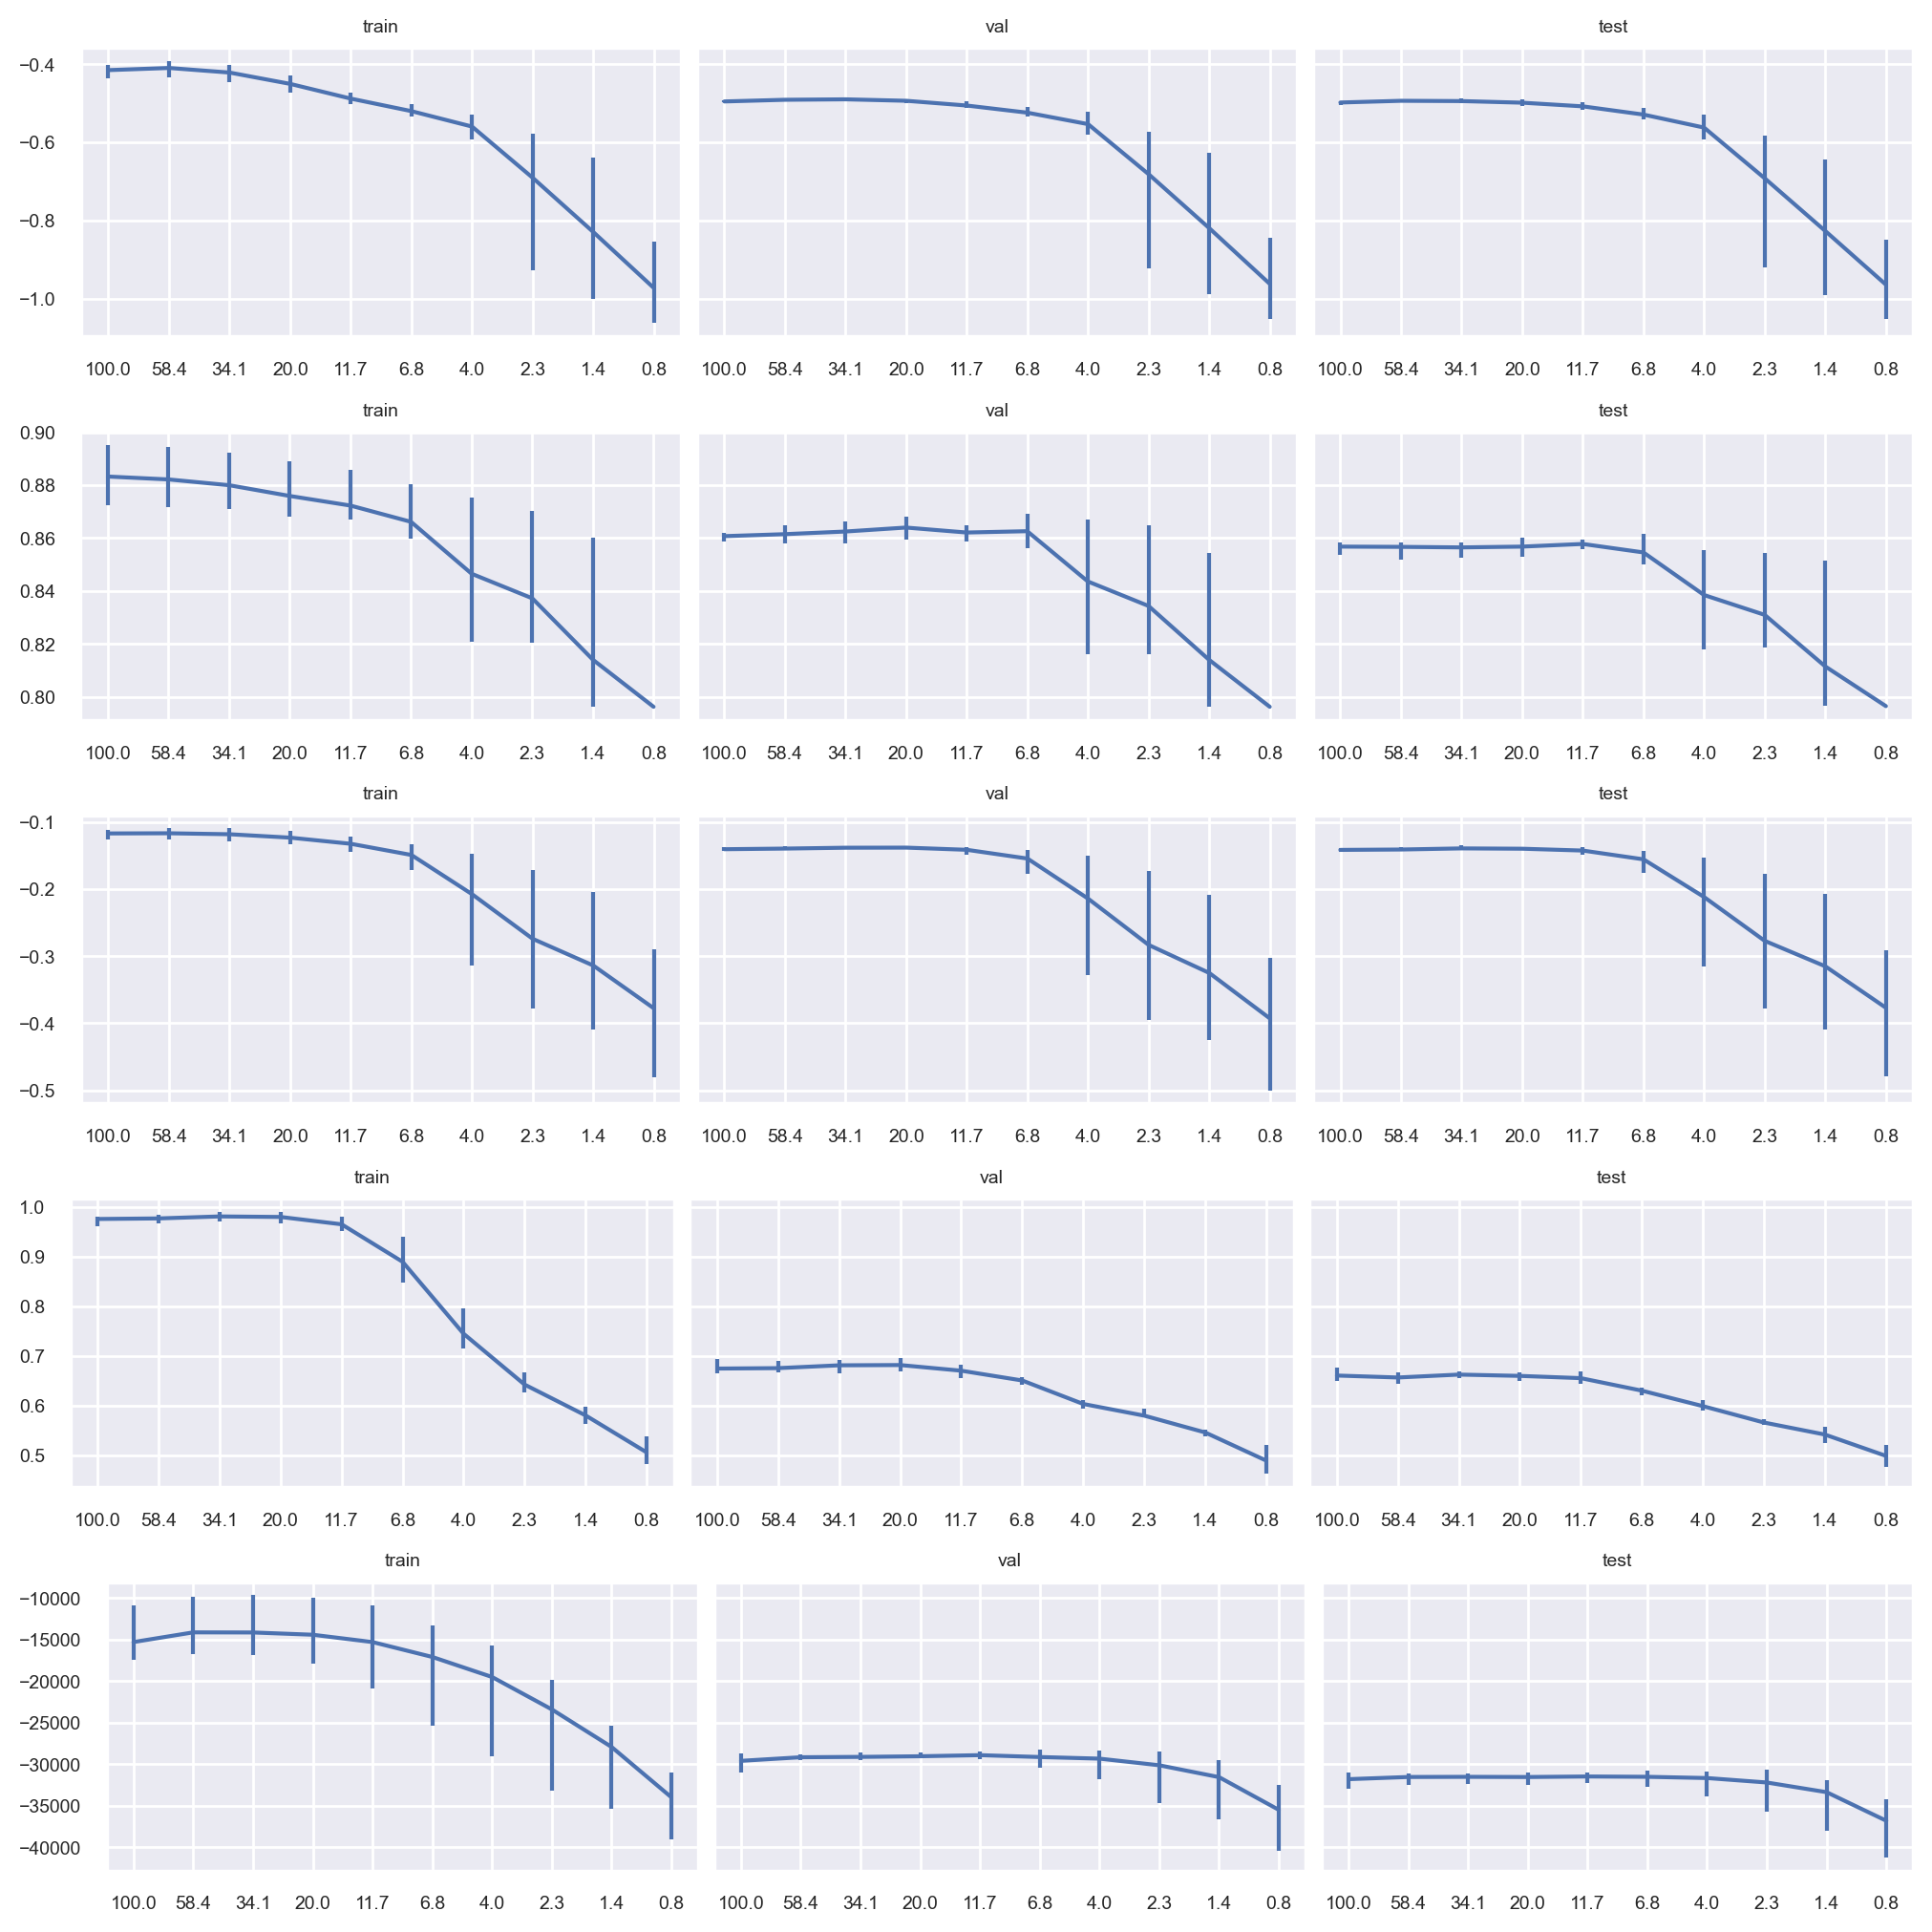

In [11]:
ds_names = ['california', 'churn', 'diamond', 'gesture', 'house']
fig = plt.figure(constrained_layout=True)
subfig = fig.subfigures(len(ds_names), 1)
xi = list(range(len(x)))
for i in range(len(ds_names)):
    axs = subfig[i].subplots(1, 3, sharey=True)
    y = get_y_by_dataset(dataset=ds_names[i], n_epochs=N_EPOCHS)
    print(ds_names[i])
    for i, k in enumerate(y.keys()):
        mean_y = np.mean(y[k], axis=0)
        axs[i].errorbar(xi, np.mean(y[k], axis=0), yerr=[mean_y - np.min(y[k], axis=0), np.max(y[k], axis=0) - mean_y])
        axs[i].title.set_text(k)
        axs[i].set_xticks(xi, x)

In [12]:
fig.savefig('images/prune')